# mlarena Basic: Explainable Generic ML Pipeline with MLflow.pyfunc

In [14]:
import pandas as pd
from sklearn.datasets import (
    fetch_california_housing,
    fetch_openml
)
from sklearn.ensemble import (
    RandomForestClassifier, 
    RandomForestRegressor
)   
from sklearn.model_selection import train_test_split
import lightgbm as lgb

from mlarena import PreProcessor, ML_PIPELINE


# Classification Demo

In [2]:
# Load data
titanic = fetch_openml('titanic', version=1, as_frame=True)
X = titanic.data
y = titanic.target.astype(int)  
X = X.drop(['boat', 'body', 'home.dest', 'ticket', 'cabin', 'name'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Fit and Use the Fitted Model

You can fit and score with mlpipeline model like you would with an sklearn model. And `evaluate` methods offer comprehensive reports including below metrics and visuals.


| Category | Classification | Regression |
|----------|---------------|------------|
| Metrics | - AUC<br>- F1 Score <br>- Fbeta (if beta specified)<br>- Precision <br>- Recall<br> | - RMSE (Root Mean Squared Error)<br>- NRMSE (Normalized RMSE as % of target mean)<br>- MAPE (Mean Absolute Percentage Error)<br>- R² Score (including adjusted R²)<br>- Improvement over baseline (%) |
| Plots | - ROC_AUC curve<br>- Precision-recall curve | - Residual analysis (residuals vs predicted values)<br>- Prediction error plot (actual vs predicted with error bands) |

<br>



Classification Metrics Report

Evaluation Parameters:
Threshold: 0.500
Beta:      1.000

Metrics:
Accuracy:  0.805
F1:        0.765
Precision: 0.838
Recall:    0.703
Pos Rate:  0.378

AUC (threshold independent):
AUC:   0.876


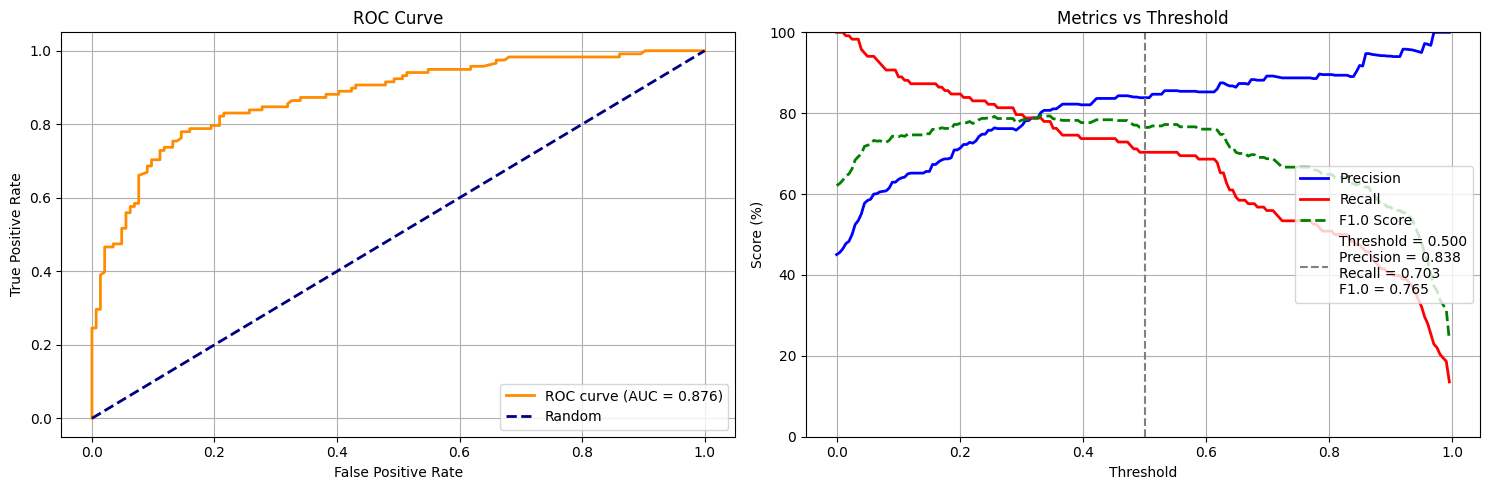

In [6]:
# define pipeline
mlpipeline = ML_PIPELINE(
    model = lgb.LGBMClassifier(verbose=-1),
    preprocessor = PreProcessor()
    )
# fit pipeline
mlpipeline.fit(X_train,y_train)
# make prediction
y_pred = mlpipeline.predict(context = None, model_input = X_test)

# evaluate pipeline with metrics and visualization
results =mlpipeline.evaluate(X_test,y_test, verbose=True, visualize=True)

## Model Explanation

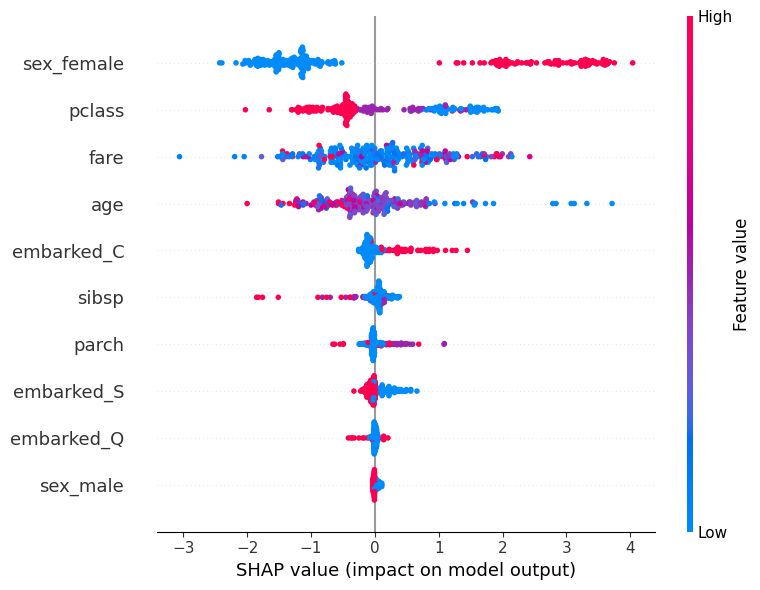

In [4]:
mlpipeline.explain_model(X_test)

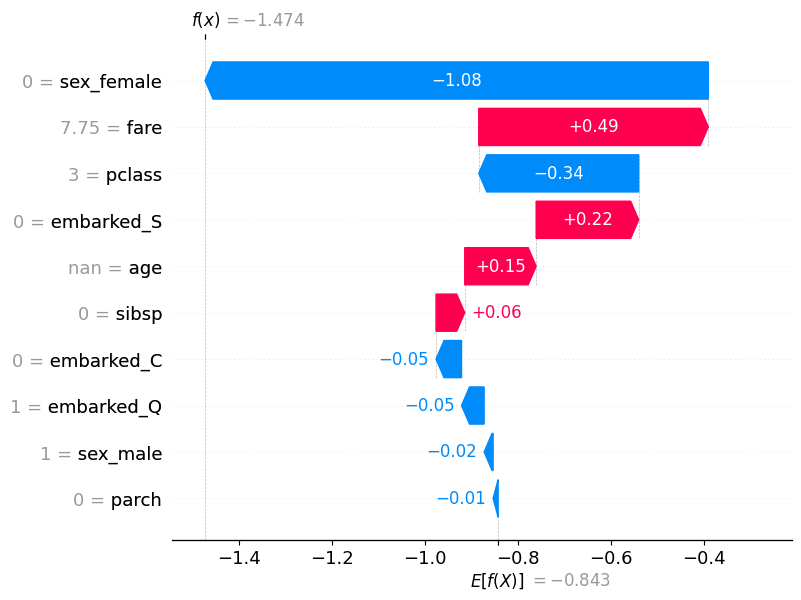

In [5]:
mlpipeline.explain_case(5)


## Swap Algorithm

Classification Metrics Report

Evaluation Parameters:
Threshold: 0.500
Beta:      1.000

Metrics:
Accuracy:  0.794
F1:        0.752
Precision: 0.820
Recall:    0.695
Pos Rate:  0.382

AUC (threshold independent):
AUC:   0.863


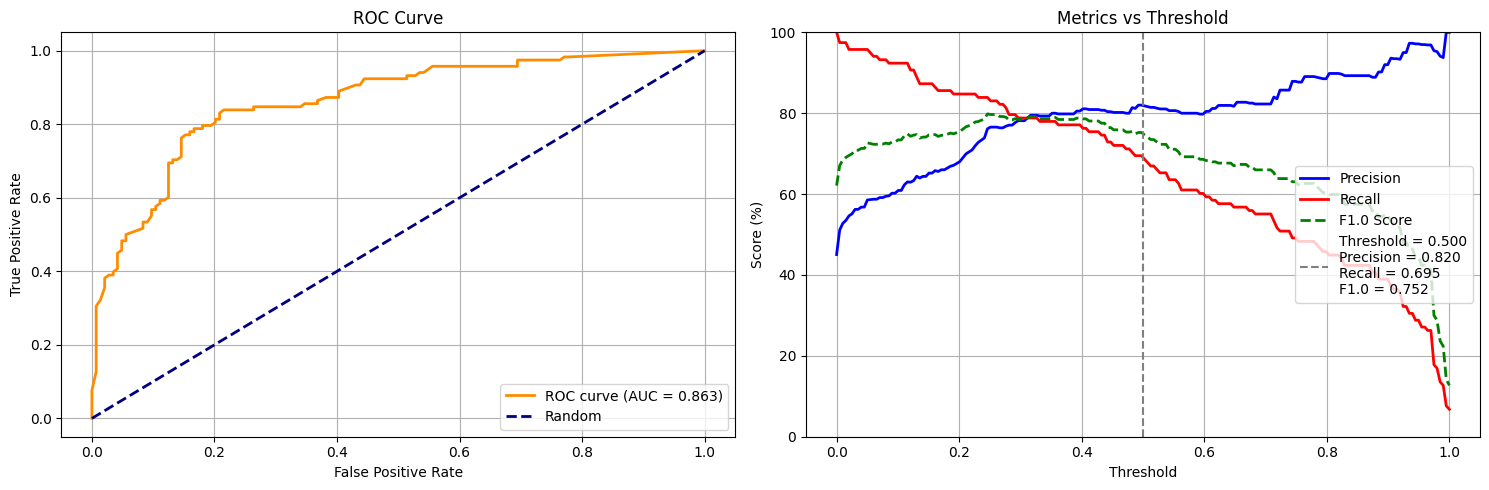

In [9]:
mlpipeline_rf = ML_PIPELINE(
    model = RandomForestClassifier(),
    preprocessor = PreProcessor()
)
mlpipeline_rf.fit(X_train,y_train)
rf_results = mlpipeline_rf.evaluate(X_test,y_test, verbose=True, visualize=True)


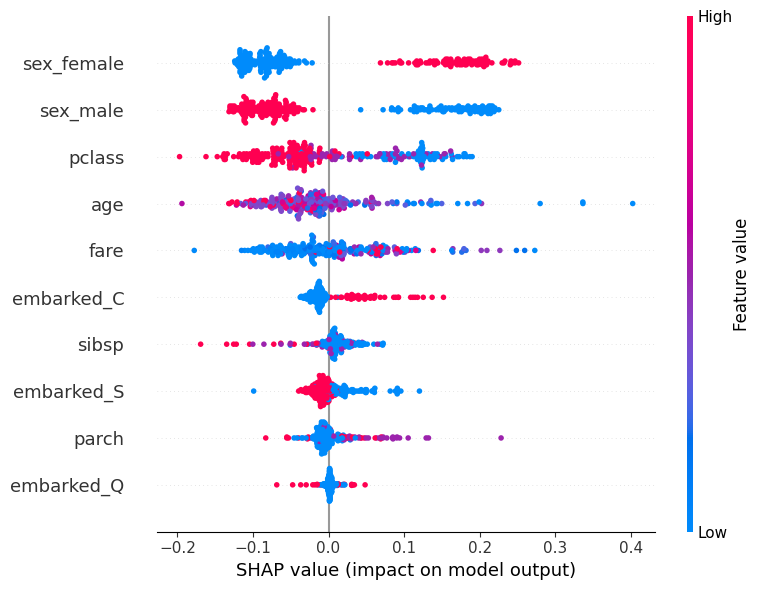

In [10]:
mlpipeline_rf.explain_model(X_test)


# Regression Demo

In [15]:
# Load data
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Fit and Use the Fitted Model

Regression Model Evaluation:
----------------------------------------
RMSE: 0.503
Normalized RMSE: 24.5% of target mean
MAPE: 18.7%
R² Score: 0.807
Adjusted R² Score: 0.806
Improvement over baseline: 56.0%


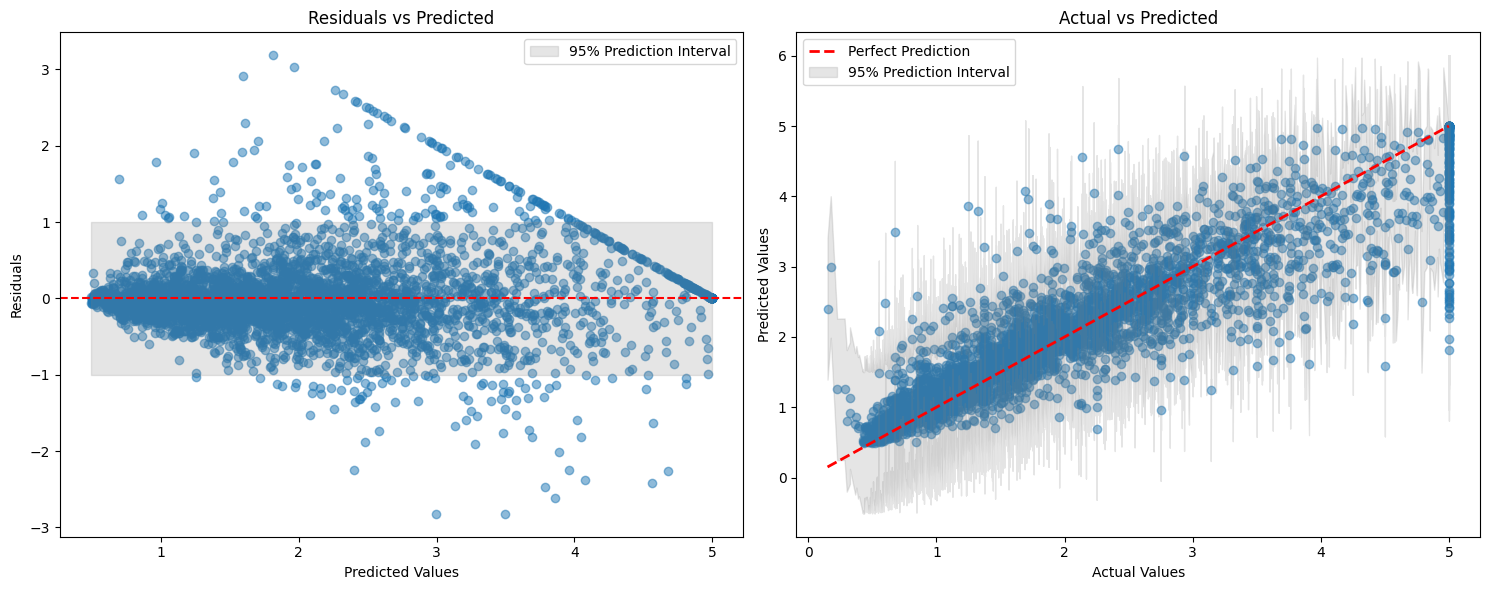

In [20]:
mlpipeline = ML_PIPELINE(
    model = RandomForestRegressor(),
    preprocessor = PreProcessor()
)
mlpipeline.fit(X_train,y_train)
results = mlpipeline.evaluate(X_test,y_test, verbose=True, visualize=True)


## Model Explanation

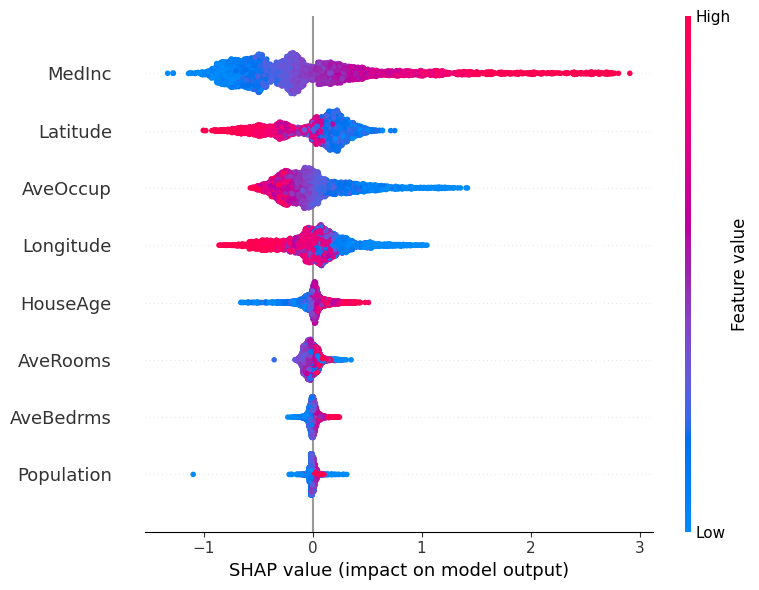

In [21]:
mlpipeline.explain_model(X_test)


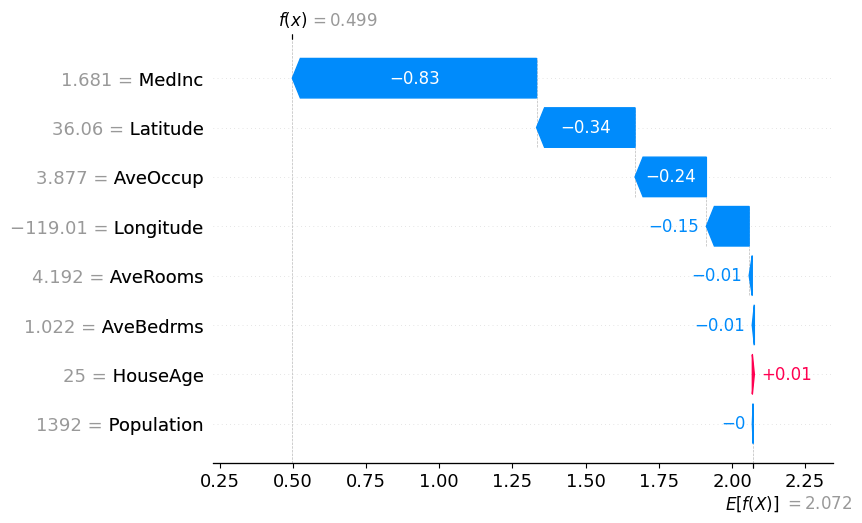

In [22]:
mlpipeline.explain_case(1)


## Swap Algorithm

In [23]:
mlpipeline_lgb = ML_PIPELINE(
    model = lgb.LGBMRegressor(),
    preprocessor = PreProcessor()
)
mlpipeline_lgb.fit(X_train,y_train)

Regression Model Evaluation:
----------------------------------------
RMSE: 0.460
Normalized RMSE: 22.4% of target mean
MAPE: 17.7%
R² Score: 0.839
Adjusted R² Score: 0.838
Improvement over baseline: 59.8%


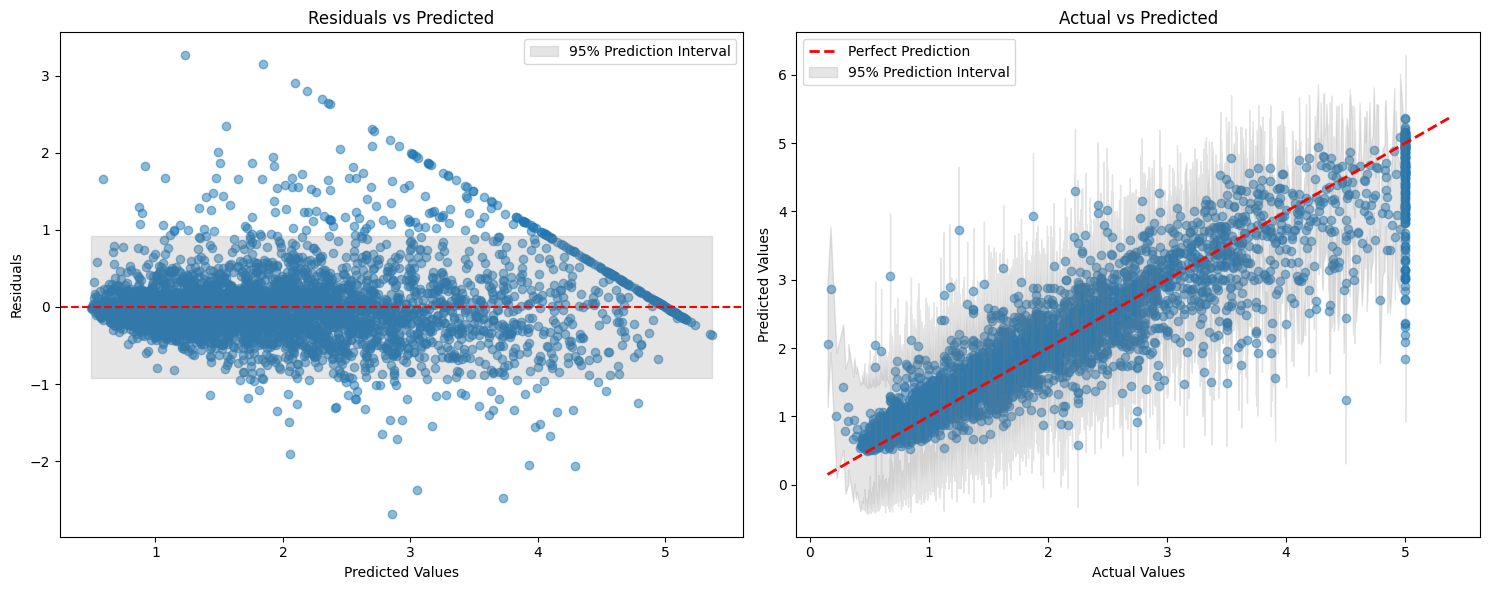

In [24]:
results = mlpipeline_lgb.evaluate(X_test,y_test, verbose=True, visualize=True)


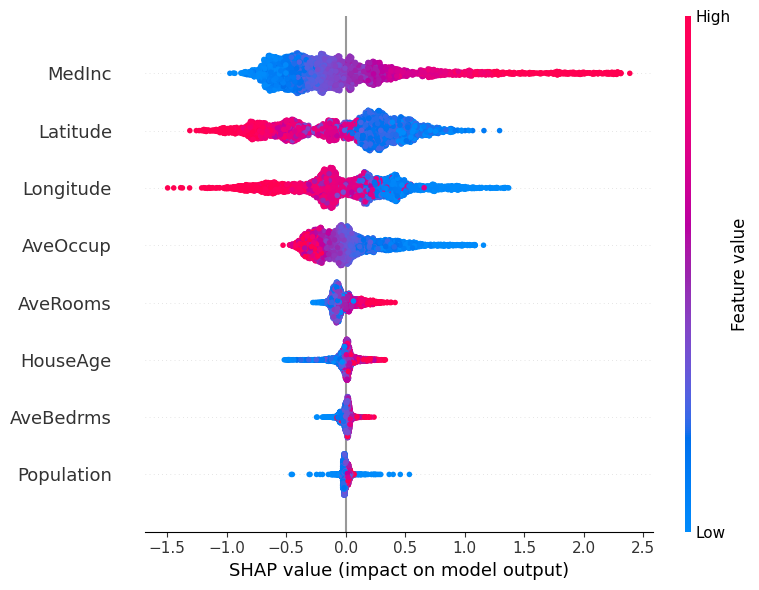

In [25]:
mlpipeline_lgb.explain_model(X_test)